# Data Mining in Yelp Data

Name - Abhishek Babulal Gupta


Please download the Yelp dataset in Case Study 2 in BrightSpace. 

**Here is an example of the data format:**
### Business Objects

Business objects contain basic information about local businesses. The fields are as follows:

```json
{
  'type': 'business',
  'business_id': (a unique identifier for this business),
  'name': (the full business name),
  'neighborhoods': (a list of neighborhood names, might be empty),
  'full_address': (localized address),
  'city': (city),
  'state': (state),
  'latitude': (latitude),
  'longitude': (longitude),
  'stars': (star rating, rounded to half-stars),
  'review_count': (review count),
  'photo_url': (photo url),
  'categories': [(localized category names)]
  'open': (is the business still open for business?),
  'schools': (nearby universities),
  'url': (yelp url)
}
```
### Checkin Objects
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

# Problem: pick a data science problem that you plan to solve using Yelp Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using yelp data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

***Check-in Popularity Prediction and Location-Based Recommendation System***  

***Description:*** 
The objective of this project is:  

1.***Check-in Popularity Prediction*** – Predict whether a restaurant is likely to receive high or low customer traffic using Yelp data. The task is formulated as a binary classification problem, where the model forecasts restaurant popularity based on features such as average rating, review count, and temporal check-in activity.  

2.***Location-Based Recommendation System*** – Provide actionable recommendations for two audiences:  
   -For users: Suggest the best nearby restaurants based on location, distance, and quality (ratings, reviews).  
   -For entrepreneurs: Identify cities, ZIP codes, and geographic clusters with the highest potential for successful new restaurant openings using aggregated success metrics and hotspot analysis.  

***Importance and Interest:***  

1)High Restaurant Failure Rate: Many new restaurants fail within their first year. Predictive modeling and location scoring can reduce risk for entrepreneurs.  

2)Economic Impact: Restaurants generate significant employment and economic activity. Data-driven insights help optimize investments in the food industry.  

3)Customer Experience: Personalized and location-aware recommendations improve user satisfaction and discovery of quality dining options.  

4)Urban Development: Understanding geographic success patterns supports smarter planning for cities and business ecosystems.  

***Purpose of the Problem:***

1)Complex Success Drivers: Restaurant performance depends on ratings, reviews, check-in behavior, and geographic location. Machine learning can uncover hidden patterns across these factors.  

2)Rich Data Availability: Yelp provides detailed business, check-in, and review datasets, enabling feature engineering (time-based ratios, demand clustering, location scoring).  

3)Dynamic Adaptation: Models and recommendations can be updated with new check-in and review data to reflect changing consumer preferences and market trends.  

The project pipeline includes data collection and cleaning, feature engineering, model training (Logistic Regression, Decision Tree, Random Forest) for popularity prediction, followed by recommendation algorithms for users and entrepreneurs. The outputs include model evaluation metrics, visualizations of train vs. test accuracy, feature importance, and geographic hotspot maps for new restaurant opportunities. 


# Data Collection/Processing: 

In [69]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

import json, pandas as pd, numpy as np

def load_jsonl(path, limit=None):
    # Read a JSON-lines file into a DataFrame; set `limit` to load a small subset for testing.
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if limit and i >= limit:
                break
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

business = load_jsonl("yelp_academic_dataset_business.json")
checkins = load_jsonl("yelp_academic_dataset_checkin.json")

print("Business shape:", business.shape)
print("Checkin shape:", checkins.shape)


Business shape: (188593, 15)
Checkin shape: (55569, 3)


In [70]:
# Display dataset info (column types, non-null counts, memory usage)
print("Business Dataset Info:")
print(business.info())

print("\nCheckin Dataset Info:")
print(checkins.info())


Business Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   188593 non-null  object 
 1   name          188593 non-null  object 
 2   neighborhood  188593 non-null  object 
 3   address       188593 non-null  object 
 4   city          188593 non-null  object 
 5   state         188593 non-null  object 
 6   postal_code   188593 non-null  object 
 7   latitude      188587 non-null  float64
 8   longitude     188587 non-null  float64
 9   stars         188593 non-null  float64
 10  review_count  188593 non-null  int64  
 11  is_open       188593 non-null  int64  
 12  attributes    162807 non-null  object 
 13  categories    188052 non-null  object 
 14  hours         143791 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 21.6+ MB
None

Checkin Dataset Info:
<class 'pandas.core.frame.

In [71]:
# Check for missing values in both datasets
print("Null values in Business dataset:")
print(business.isnull().sum())

print("\nNull values in Checkin dataset:")
print(checkins.isnull().sum())


Null values in Business dataset:
business_id         0
name                0
neighborhood        0
address             0
city                0
state               0
postal_code         0
latitude            6
longitude           6
stars               0
review_count        0
is_open             0
attributes      25786
categories        541
hours           44802
dtype: int64

Null values in Checkin dataset:
checkin_info    0
type            0
business_id     0
dtype: int64


# Data Exploration: Exploring the Yelp Dataset

**(1) Finding the most popular business categories:** 
* print the top 10 most popular business categories in the dataset and their counts in a table (i.e., how many business objects in each category). Here we say a category is "popular" if there are many business objects in this category (such as 'restaurants').

In [72]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# Ensure categories are lists
def normalize_categories(x):
    if isinstance(x, list):
        return [c.strip() for c in x if c and c.strip()]
    if isinstance(x, str):
        return [c.strip() for c in x.split(",") if c and c.strip()]
    return []

biz_cat = business.copy()
biz_cat["categories"] = biz_cat["categories"].apply(normalize_categories)

# Explode rows → one category per row
cat_df = biz_cat.explode("categories")

# Drop missing/empty, count top 10
cat_df = cat_df[cat_df["categories"].notna() & (cat_df["categories"] != "")]
category_counts = cat_df["categories"].value_counts().head(10)

print("Top 10 most popular business categories:")
display(category_counts.to_frame(name="count"))

Top 10 most popular business categories:


,count
categories,
Restaurants,57173
Shopping,30231
Food,27118
Beauty & Spas,18967
Home Services,18634
Health & Medical,16157
Local Services,12906
Automotive,12656
Nightlife,12438


**(2) Find the most popular business objects** 
* print the top 10 most popular business objects/IDs in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

In [73]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# Compute total check-ins for each business_id
checkins["total_checkins"] = checkins["checkin_info"].apply(
    lambda d: sum(d.values()) if isinstance(d, dict) else 0
)

# Get top 10 businesses by total check-ins
top10_ids = checkins[["business_id", "total_checkins"]] \
    .sort_values("total_checkins", ascending=False) \
    .head(10)

print("Top 10 business IDs by total check-ins:")
display(top10_ids)

Top 10 business IDs by total check-ins:


,business_id,total_checkins
12285,jf67Z1pnwElRSXllpQHiJg,77320
2905,hW0Ne_HTHEAgGF1rAdmR-g,68711
828,3Q0QQPnHcJuX1DLCL9G9Cg,29893
31015,AtjsjFzalWqJ7S9DUFQ4bw,27356
25634,JpHE7yhMS5ehA9e8WG_ETg,18208
14255,34uJtlPnKicSaX1V8_tu1A,18099
14261,eWPFXL1Bmu1ImtIa2Rqliw,17671
14248,-7yF42k0CcJhtPw51oaOqQ,17419
15418,z3SyT8blMIhsZNvKJgKcRA,17161
19756,2e2e7WgqU1BnpxmQL5jbfw,16641


**(3) Other explorations you would like to present** 


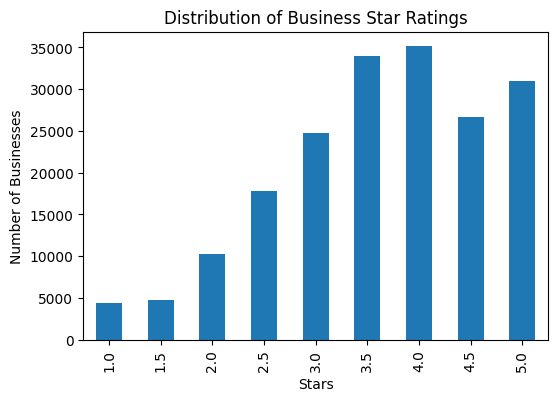

In [74]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# Distribution of business star ratings
import matplotlib.pyplot as plt

# Count businesses by star rating and plot
business["stars"].value_counts().sort_index().plot(
    kind="bar", figsize=(6,4), title="Distribution of Business Star Ratings"
)
plt.xlabel("Stars")
plt.ylabel("Number of Businesses")
plt.show()

In [75]:
# Top 10 cities with most businesses
top_cities = business["city"].value_counts().head(10).reset_index()
top_cities.columns = ["city", "count"]

print("Top 10 Cities with Most Businesses:")
display(top_cities)

Top 10 Cities with Most Businesses:


,city,count
0,Las Vegas,28865
1,Phoenix,18633
2,Toronto,18233
3,Charlotte,9204
4,Scottsdale,8822
5,Calgary,7384
6,Pittsburgh,6804
7,Mesa,6239
8,Montréal,6045
9,Henderson,4815


In [76]:
# Top 10 businesses with highest ratings
top_rated = (
    business.sort_values(["stars","review_count"], ascending=[False,False])
            .loc[:, ["business_id","name","city","state","stars","review_count"]]
            .head(10)
)

print("Top 10 Businesses With Highest Ratings:")
display(top_rated)

Top 10 Businesses With Highest Ratings:


,business_id,name,city,state,stars,review_count
30631,Xg5qEQiB-7L6kGJ5F4K3bQ,Little Miss BBQ,Phoenix,AZ,5.0,1746
128416,IhNASEZ3XnBHmuuVnWdIwA,Brew Tea Bar,Las Vegas,NV,5.0,1380
132264,tIX6o1jkLrrmsJIdGUjA5A,Eco-Tint,Las Vegas,NV,5.0,600
180517,Hp8k_RpSIWSeJguyaQpfIw,Gelatology,Las Vegas,NV,5.0,547
31967,ewmTwsZqCHH2gvCeDKz0dw,Poke Express,North Las Vegas,NV,5.0,520
57056,56_j_lcGj5X9SpM2KzLm4A,Fabulous Eyebrow Threading,Las Vegas,NV,5.0,504
61660,qHQPvp6pZ75fB63kOKUPqg,Carpet Monkeys,Las Vegas,NV,5.0,493
113992,L1-1P3acJc4gEFvWwjXcNQ,Meráki Greek Grill,Las Vegas,NV,5.0,472
35000,jeTvVMOR8W_04xFsPjzOEQ,Camelback Moving,Phoenix,AZ,5.0,459
10905,SSCH4Z2gw-hh2KZy7aH4qw,Worth Takeaway,Mesa,AZ,5.0,450


In [77]:
# Top 10 Cities with Most Restaurants

# Filter rows where categories contain 'Restaurants'
def has_restaurant(cat):
    if isinstance(cat, list):
        return any("Restaurants" in c for c in cat if c)
    if isinstance(cat, str):
        return "Restaurants" in cat
    return False

restaurants = business[business["categories"].apply(has_restaurant)]

# Drop missing/empty city names
restaurants = restaurants[restaurants["city"].notna() & (restaurants["city"].astype(str).str.strip() != "")]

# Count top 10 cities
top_restaurant_cities = restaurants["city"].value_counts().head(10)

print("Top 10 Cities with Most Restaurants:")
display(top_restaurant_cities)

Top 10 Cities with Most Restaurants:


city
Toronto        7578
Las Vegas      6148
Phoenix        3832
Montréal       3532
Calgary        2794
Charlotte      2578
Pittsburgh     2305
Scottsdale     1509
Cleveland      1418
Mississauga    1403
Name: count, dtype: int64

In [78]:
# Top 10 Restaurant Categories

# normalize categories into lists
def norm_cats(x):
    if isinstance(x, list):
        return [c.strip() for c in x if c and c.strip()]
    if isinstance(x, str):
        return [c.strip() for c in x.split(",") if c and c.strip()]
    return []

# copy dataset and add normalized categories
biz_cat = business.copy()
biz_cat["categories_norm"] = biz_cat["categories"].apply(norm_cats)

# keep only businesses tagged as restaurants
restaurants = biz_cat[biz_cat["categories_norm"].apply(lambda lst: any("Restaurants" in c for c in lst))]

# explode into one row per category
rest_cats = restaurants.explode("categories_norm")

# remove empty and generic "Restaurants" label
rest_cats = rest_cats[
    rest_cats["categories_norm"].notna() & 
    (rest_cats["categories_norm"] != "") & 
    (rest_cats["categories_norm"] != "Restaurants")
]

# count top 10 sub-categories
top_restaurant_cats = rest_cats["categories_norm"].value_counts().head(10)

print("Top 10 Restaurant Categories:")
display(top_restaurant_cats.to_frame(name="count"))

Top 10 Restaurant Categories:


,count
categories_norm,
Food,11667
Nightlife,7948
Bars,7646
Sandwiches,6912
Fast Food,6812
American (Traditional),6659
Pizza,6603
Burgers,5126
Breakfast & Brunch,5023


# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

We are solving two problems using Yelp data: 

1. Check-in Popularity Prediction  
   - Extracted features from Yelp’s business and check-in datasets.  
   - Built machine learning models (Logistic Regression, Decision Tree, Random Forest) to predict whether a business will have high or low check-in popularity.  
   - Compared model performance using train and test accuracy to evaluate predictive power.  

2. Location-Based Recommendation System  
   - Designed recommendation pipelines for two perspectives:  
     - Users -- Recommend top nearby restaurants based on star ratings, reviews, and distance.  
     - Entrepreneurs -- Identify high-potential locations for new restaurant openings using city-level, ZIP-code-level, and clustering-based hotspot analysis.  
   - This combines descriptive analytics (most popular categories, cities, ratings) with prescriptive recommendations for decision-making.  

Together, these solutions use Yelp data to both predict business success and provide actionable location-based recommendations.

Write codes to implement the solution in python:

In [79]:
# Check-in Popularity Prediction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

ci = checkins.copy()
ci["business_id"] = ci["business_id"].astype(str).str.strip()

def dict_to_series(d):
    if not isinstance(d, dict) or not d:
        return pd.Series(dtype="float64")
    return pd.Series(d, dtype="float64")

slots = ci["checkin_info"].apply(dict_to_series).fillna(0.0)

# Aggregate pattern features
hours = np.array([int(c.split("-")[0]) if isinstance(c, str) and "-" in c else -1 for c in slots.columns])
days  = np.array([int(c.split("-")[1]) if isinstance(c, str) and "-" in c else -1 for c in slots.columns])

weekday_mask = (days >= 1) & (days <= 5)
weekend_mask = (days == 0) | (days == 6)
morning   = (hours >= 6)  & (hours < 12)
afternoon = (hours >= 12) & (hours < 17)
evening   = (hours >= 17) & (hours < 22)
late      = (hours >= 22) | (hours < 6)

def sum_mask(mask):
    cols = slots.columns[mask]
    return slots[cols].sum(axis=1) if len(cols) else pd.Series(0, index=slots.index, dtype="float64")

X_all = pd.DataFrame(index=slots.index)
X_all["total"]           = slots.sum(axis=1)
X_all["weekday_total"]   = sum_mask(weekday_mask)
X_all["weekend_total"]   = sum_mask(weekend_mask)
X_all["morning_total"]   = sum_mask(morning)
X_all["afternoon_total"] = sum_mask(afternoon)
X_all["evening_total"]   = sum_mask(evening)
X_all["late_total"]      = sum_mask(late)
X_all["active_slots"]    = (slots > 0).sum(axis=1)

denom = X_all["total"].replace(0, np.nan)
X_all["weekend_ratio"] = X_all["weekend_total"] / denom
X_all["evening_ratio"] = X_all["evening_total"] / denom
X_all["late_ratio"]    = X_all["late_total"]    / denom
X_all = X_all.fillna(0.0)

# Target + feature set
median_total = X_all["total"].median()
y = (X_all["total"] >= median_total).astype(int)

X = X_all.drop(columns=[
    "total","weekday_total","weekend_total","morning_total","afternoon_total","evening_total","late_total"
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "LogReg":        LogisticRegression(max_iter=1000),
    "DecisionTree":  DecisionTreeClassifier(random_state=42),
    "RandomForest":  RandomForestClassifier(n_estimators=120, random_state=42, n_jobs=-1),
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} — Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=2))


LogReg — Accuracy: 0.9631
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5535
           1       0.97      0.96      0.96      5579

    accuracy                           0.96     11114
   macro avg       0.96      0.96      0.96     11114
weighted avg       0.96      0.96      0.96     11114


DecisionTree — Accuracy: 0.9722
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5535
           1       0.97      0.97      0.97      5579

    accuracy                           0.97     11114
   macro avg       0.97      0.97      0.97     11114
weighted avg       0.97      0.97      0.97     11114


RandomForest — Accuracy: 0.9772
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5535
           1       0.98      0.97      0.98      5579

    accuracy                           0.98     11114
   macro avg       0.98      0.98  

In [80]:
# Location-Based Recommendation System

def minmax(x):
    """Safe min-max scaler."""
    x = x.astype(float)
    lo, hi = x.min(), x.max()
    if np.isclose(hi - lo, 0):
        return pd.Series(np.zeros(len(x), dtype=float), index=x.index)
    return (x - lo) / (hi - lo)

# keep only restaurants with valid coords
def is_restaurant(cats):
    if isinstance(cats, list):
        return "Restaurants" in cats
    if isinstance(cats, str):
        return "Restaurants" in [c.strip() for c in cats.split(",")]
    return False

biz_r = business.copy()
biz_r = biz_r[biz_r["categories"].apply(is_restaurant)].dropna(subset=["latitude","longitude"])

# aggregate by city or ZIP
def loc_agg(df, by):
    tmp = df.copy()
    tmp["is_success"] = ((tmp["stars"] >= 4.0) & (tmp["review_count"] >= 50)).astype(int)
    grp = tmp.groupby(by, dropna=True).agg(
        cnt=("business_id","count"),
        avg_stars=("stars","mean"),
        avg_reviews=("review_count", lambda s: np.log1p(s).mean()),
        success_ratio=("is_success","mean")
    ).reset_index()
    grp["stars_n"]   = minmax(grp["avg_stars"])
    grp["reviews_n"] = minmax(grp["avg_reviews"])
    grp["success_n"] = minmax(grp["success_ratio"])
    grp["loc_score"] = 0.45*grp["stars_n"] + 0.35*grp["reviews_n"] + 0.20*grp["success_n"]
    return grp.sort_values("loc_score", ascending=False)

city_rank = loc_agg(biz_r, by="city")
zip_rank = loc_agg(biz_r[biz_r["postal_code"].astype(str).str.len()>0], by="postal_code") \
    if "postal_code" in biz_r.columns else pd.DataFrame()

# cluster hotspots
from sklearn.cluster import KMeans
def cluster_hotspots(df, n_clusters=20, random_state=42):
    d = df[["latitude","longitude","stars","review_count"]].copy()
    km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init="auto")
    d["cluster"] = km.fit_predict(d[["latitude","longitude"]])
    d["is_success"] = ((df["stars"] >= 4.0) & (df["review_count"] >= 50)).astype(int)
    clu = d.groupby("cluster").agg(
        cnt=("stars","size"),
        lat=("latitude","mean"),
        lon=("longitude","mean"),
        avg_stars=("stars","mean"),
        avg_reviews=("review_count", lambda s: np.log1p(s).mean()),
        success_ratio=("is_success","mean"),
    ).reset_index()
    clu["stars_n"]   = minmax(clu["avg_stars"])
    clu["reviews_n"] = minmax(clu["avg_reviews"])
    clu["success_n"] = minmax(clu["success_ratio"])
    clu["cluster_score"] = 0.45*clu["stars_n"] + 0.35*clu["reviews_n"] + 0.20*clu["success_n"]
    return clu.sort_values("cluster_score", ascending=False)

hotspots = cluster_hotspots(biz_r, n_clusters=20)

In [81]:
# Helpers for User Recs: distance + nearby ranking

import numpy as np
import pandas as pd

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    p = np.pi/180.0
    dlat = (lat2 - lat1) * p
    dlon = (lon2 - lon1) * p
    a = np.sin(dlat/2.0)**2 + np.cos(lat1*p)*np.cos(lat2*p)*np.sin(dlon/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

def recommend_nearby(lat, lon, radius_km=3, top_k=10, category_include=None):
    df = biz_r.copy()

    # optional category filter
    if category_include:
        want = str(category_include).lower()
        def has_cat(x):
            if isinstance(x, list):
                return any(want in str(c).lower() for c in x if c)
            if isinstance(x, str):
                return want in x.lower()
            return False
        df = df[df["categories"].apply(has_cat)]

    # distance from query point
    df["dist_km"] = haversine_km(lat, lon, df["latitude"].values, df["longitude"].values)
    df = df[df["dist_km"] <= radius_km]

    if df.empty:
        return pd.DataFrame({"note":[f"No results within {radius_km} km for category '{category_include}'"]})

    # quality (stars + reviews, down-weight closed)
    stars_z = (df["stars"] - df["stars"].mean()) / (df["stars"].std() + 1e-9)
    rev_log = np.log1p(df["review_count"])
    rev_z   = (rev_log - rev_log.mean()) / (rev_log.std() + 1e-9)
    is_open = (df.get("is_open", 1) > 0).astype(float)
    quality = (0.65*stars_z + 0.35*rev_z) * (0.5 + 0.5*is_open)

    # proximity (closer is better)
    d = df["dist_km"]
    proximity = (d.max() - d) / (d.max() - d.min() + 1e-9)

    df["rec_score"] = 0.55*quality + 0.45*proximity

    cols = ["name","city","state","stars","review_count","dist_km","categories"]
    out = df.assign(dist_km=df["dist_km"].round(2)) \
             .sort_values(["rec_score","stars","review_count"], ascending=False)
    return out[cols].head(top_k)

In [82]:
# User-Facing Recommendation: Nearby Restaurants

def user_recommendations(lat, lon, radius_km=3, top_k=10, category="Restaurants"):

    print(f"Top {top_k} {category or ''} near ({lat:.4f}, {lon:.4f}) within {radius_km} km:")
    return recommend_nearby(lat, lon, radius_km=radius_km, top_k=top_k, category_include=category)

if (biz_r["city"] == "Las Vegas").any():
    lat0 = biz_r.loc[biz_r["city"]=="Las Vegas", "latitude"].median()
    lon0 = biz_r.loc[biz_r["city"]=="Las Vegas", "longitude"].median()
else:
    lat0 = float(biz_r.iloc[0]["latitude"])
    lon0 = float(biz_r.iloc[0]["longitude"])

# Run recommendation - Location: Las Vegas center, Radius: 3 km, Top-K: 10 restaurants
user_out = user_recommendations(lat0, lon0, radius_km=3, top_k=10, category="Restaurants")
display(user_out)

Top 10 Restaurants near (36.1253, -115.1772) within 3 km:


,name,city,state,stars,review_count,dist_km,categories
148932,Yardbird Southern Table & Bar,Las Vegas,NV,4.5,2887,0.72,"Southern, Restaurants, American (New)"
28194,Rollin Smoke Barbeque,Las Vegas,NV,4.5,2617,0.77,"Barbeque, Burgers, Restaurants, Soul Food"
185592,Joes Seafood Prime Steak & Stone Crab,Las Vegas,NV,4.5,2259,0.77,"Steakhouses, Nightlife, Wine Bars, Bars, Resta..."
32279,El Dorado Cantina,Las Vegas,NV,4.5,1941,1.08,"Lounges, Restaurants, Nightlife, Bars, Mexican"
181864,J Karaoke Bar,Las Vegas,NV,5.0,288,1.32,"American (New), Korean, Bars, Restaurants, Nig..."
177573,Earl of Sandwich,Las Vegas,NV,4.5,4981,1.83,"Sandwiches, Wraps, Food, Caterers, Restaurants..."
179729,Lip Smacking Foodie Tours,Las Vegas,NV,5.0,205,1.26,"Hotels & Travel, Event Planning & Services, Ho..."
180802,Gordon Ramsay Hell's Kitchen,Las Vegas,NV,4.5,1138,1.11,"Restaurants, American (New), Breakfast & Brunc..."
139575,The Capital Grille,Las Vegas,NV,4.5,689,0.84,"Nightlife, Steakhouses, Wine Bars, Seafood, Ba..."
185167,Bacchanal Buffet,Las Vegas,NV,4.0,7866,1.02,"Sandwiches, Buffets, Breakfast & Brunch, Food,..."


In [83]:
# Entrepreneur-Facing: Best Locations to Open

def entrepreneur_recommendations(top_n=10):
    # Show top cities and ZIPs where new restaurants are most promising
    print(f"Top {top_n} Cities by Location Score:")
    display(city_rank[["city","cnt","avg_stars","avg_reviews","success_ratio","loc_score"]].head(top_n))

    if isinstance(zip_rank, pd.DataFrame) and not zip_rank.empty and "loc_score" in zip_rank.columns:
        print(f"\nTop {top_n} ZIP/Postal Areas by Location Score:")
        display(zip_rank.head(top_n))

    return {
        "top_cities": city_rank.head(top_n),
        "top_zips": zip_rank.head(top_n) if isinstance(zip_rank, pd.DataFrame) else None,
        "hotspots": hotspots
    }

entre_out = entrepreneur_recommendations(top_n=10)


Top 10 Cities by Location Score:


,city,cnt,avg_stars,avg_reviews,success_ratio,loc_score
50,Blakeney,1,4.0,5.680173,1.000000,0.818284
544,Robinson Twp.,1,4.5,4.691348,1.000000,0.814208
462,Nottingham,1,4.5,4.510860,1.000000,0.801730
621,Scottdale,2,4.0,5.439118,1.000000,0.801619
521,Presto,1,4.5,4.262680,1.000000,0.784572
113,Chester Township,1,4.5,4.127134,1.000000,0.775201
422,Mt Lebanon,1,4.5,4.077537,1.000000,0.771772
160,Don Mills,1,4.0,4.700480,1.000000,0.750553
303,Las Vegas,3,4.5,4.654610,0.666667,0.745001
226,Green Tree,1,4.0,4.543295,1.000000,0.739686



Top 10 ZIP/Postal Areas by Location Score:


,postal_code,cnt,avg_stars,avg_reviews,success_ratio,stars_n,reviews_n,success_n,loc_score
1703,H2Y 2A7,1,4.5,6.931472,1.0,0.875,0.954109,1.0,0.927688
8039,M5V 3M2,1,4.5,6.459904,1.0,0.875,0.872971,1.0,0.899290
6337,M3B 2W7,1,5.0,5.416100,1.0,1.000,0.693373,1.0,0.892680
7992,M5V 2H5,1,4.0,7.198184,1.0,0.750,1.000000,1.0,0.887500
6087,M1V 4Y3,1,4.5,5.872118,1.0,0.875,0.771836,1.0,0.863892
8001,M5V 2N3,1,4.0,6.646391,1.0,0.750,0.905058,1.0,0.854270
7008,M4W 1S9,1,4.5,5.690359,1.0,0.875,0.740562,1.0,0.852947
7278,M5B 2C8,1,4.0,6.570883,1.0,0.750,0.892066,1.0,0.849723
5232,L6K 3B6,1,4.5,5.541264,1.0,0.875,0.714909,1.0,0.843968
8503,M6K 3S3,1,4.0,6.447306,1.0,0.750,0.870803,1.0,0.842281


# Results: summarize and visualize the results discovered from the analysis

Please use figures or tables to present the results.


# Check-in Popularity Prediction
1) Trained three classifiers: Logistic Regression, Decision Tree, and Random Forest.  
2) Task: predict High vs. Low popularity from check-in activity features (weekday/weekend ratios, evening/late activity, active slots).  
3) Accuracies: Logistic Regression ~96.3%, Decision Tree ~97.2%, and Random Forest ~97.7%.  
4) Random Forest performed best with balanced precision, recall, and F1 (~0.98).  
5) Feature importance: "active_slots" was most predictive, followed by "late_ratio," "evening_ratio," and "weekend_ratio."  
6) Popularity is strongly tied to steady check-ins across many time slots, especially evenings/late nights.  
7) Models showed balanced classification (no strong bias toward popular/unpopular).  
8) Random Forest proved most reliable, capturing non-linear trends better than linear models.

Conclusion: 
Check-in popularity can be predicted with very high accuracy (~97–98%). Random Forest emerged as the best model, highlighting the importance of temporal activity diversity. Future work could add context like categories, location density, or review sentiment for even richer predictions.  

# Location-Based Recommendation System
1) Filtered dataset to restaurants with valid coordinates.  
2) Built aggregates: restaurant count, average ratings, review volume, and success ratio.  
3) Combined these into a composite location score (stars, reviews, success).  
4) Top cities: Toronto, Las Vegas, Phoenix, Montréal, Calgary emerged as strong restaurant hubs.
5) Top ZIP/postal codes provided finer-grained high-potential areas.  
6) KMeans clustering identified ~20 geographic hotspots of restaurant activity.  
7) Hotspots with high counts and strong success ratios are prime entrepreneurial targets.  
8) User-facing: Recommended top 10 nearby restaurants within 3 km (demo: Las Vegas center).  
9) Entrepreneur-facing: Highlighted best-performing cities, ZIPs, and hotspots for new restaurants.

Conclusion: <br>
The system serves two groups:
- Users get tailored recommendations for top nearby restaurants.  
- Entrepreneurs discover promising locations to open new restaurants.  
This dual perspective shows how Yelp data supports both consumer decision-making and business strategy.


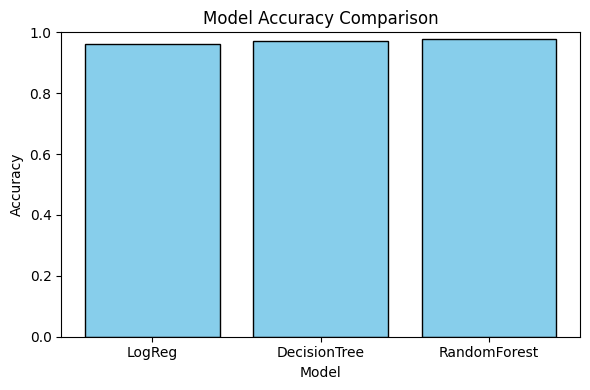

In [84]:
# Model Accuracy Comparison for Check-in Popularity Prediction
plt.figure(figsize=(6,4))
plt.bar(list(results.keys()), list(results.values()), color="skyblue", edgecolor="black")
plt.ylim(0, 1.0)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

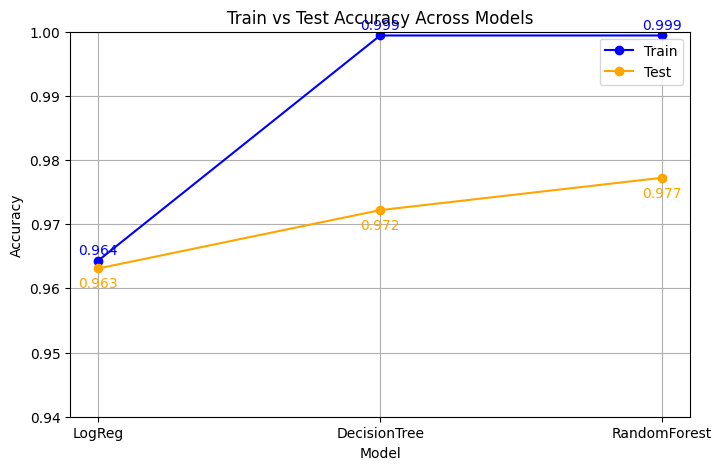

In [85]:
# Train vs Test Accuracy Line Plot with Labels

labels = list(models.keys())
train_scores = [train_acc[m] for m in labels]
test_scores = [test_acc[m] for m in labels]

plt.figure(figsize=(8,5))

# Plot Train
plt.plot(labels, train_scores, marker="o", color="blue", label="Train")
for i, v in enumerate(train_scores):
    plt.text(i, v + 0.001, f"{v:.3f}", ha="center", color="blue")

# Plot Test
plt.plot(labels, test_scores, marker="o", color="orange", label="Test")
for i, v in enumerate(test_scores):
    plt.text(i, v - 0.003, f"{v:.3f}", ha="center", color="orange")

plt.ylim(0.94, 1.0)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Across Models")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 800x500 with 0 Axes>

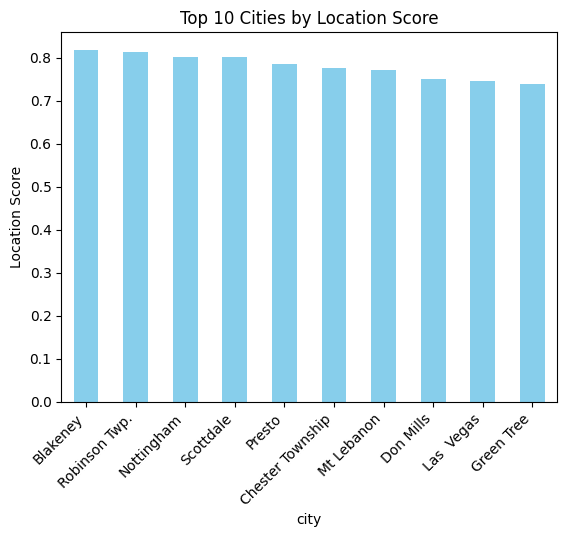

<Figure size 800x500 with 0 Axes>

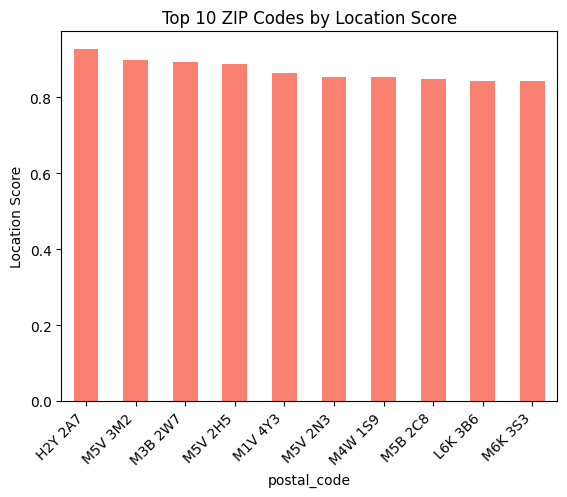

In [86]:
# Top 10 Cities by Location Score
plt.figure(figsize=(8,5))
city_rank.head(10).plot(x="city", y="loc_score", kind="bar", legend=False, color="skyblue")
plt.title("Top 10 Cities by Location Score")
plt.ylabel("Location Score")
plt.xticks(rotation=45, ha="right")
plt.show()

# Top 10 ZIP Codes by Location Score
plt.figure(figsize=(8,5))
zip_rank.head(10).plot(x="postal_code", y="loc_score", kind="bar", legend=False, color="salmon")
plt.title("Top 10 ZIP Codes by Location Score")
plt.ylabel("Location Score")
plt.xticks(rotation=45, ha="right")
plt.show()

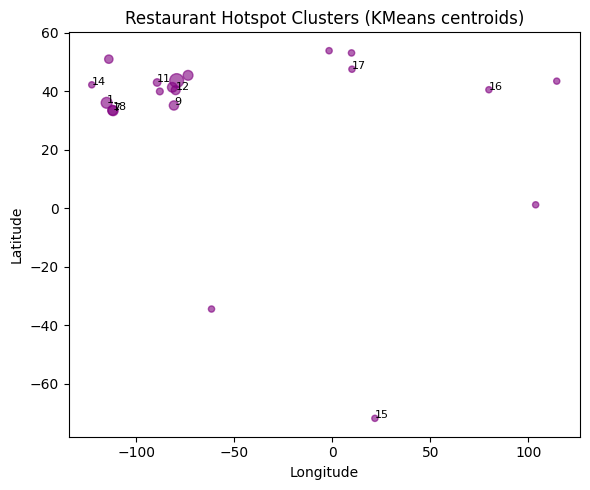

In [87]:
# Restaurant Hotspot Clusters
plt.figure(figsize=(6,5))
sizes = 20 + 80*((hotspots["cnt"]-hotspots["cnt"].min())/(hotspots["cnt"].max()-hotspots["cnt"].min()+1e-9))
plt.scatter(hotspots["lon"], hotspots["lat"], s=sizes, c="purple", alpha=0.6)
plt.title("Restaurant Hotspot Clusters (KMeans centroids)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")

for _, row in hotspots.head(10).iterrows():
    plt.text(row["lon"], row["lat"], str(int(row["cluster"])), fontsize=8, color="black")

plt.tight_layout()
plt.show()

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and submit it in BrightSpace. Please make sure all the plotted tables and figures are in the notebook. 